In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import factorial
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)

In [2]:
#
#
# In this notebook, we explore the basic properties of the InstaCart datasets. Our
# mission here is to:
#   1. Familiarize ourselves with the structure of the data sets,
#   2. Understand basic statistics about the data, to get a feel for
#      what we might be able to do with the data
#   3. Assess data quality and perform basic sanity checks. Do the data
#      agree with the claimed specs? Are values missing? Are some values
#      clearly insane and need to be removed?
#   4. Develop a baseline strategy for answering the data challenge.
#
#

In [3]:
print "Reading prior orders data ... ",
order_prior = pd.read_csv('order_products__prior.csv')
print "done."


Reading prior orders data ...  done.


In [4]:
#
# What is the distribution of basket sizes?
#

# group entries by order (aka "basket")
op_by_oid = order_prior.groupby('order_id')

# compute basket size (slow)
basket_sizes = op_by_oid.apply(len)

In [5]:
# basic summary statistics
min_bs = min(basket_sizes)
max_bs = max(basket_sizes)
pctiles = list(basket_sizes.quantile([0.1, 0.5, 0.9]))
print "Total purchases:", len(order_prior)
print "Total baskets:", len(basket_sizes)
print
print "Min basket size:", min_bs
print "Max basket size:", max_bs
print "Percentiles:"
print "\t10:", pctiles[0]
print "\t50:", pctiles[1]
print "\t90:", pctiles[2]
print "Avg basket size: %.3f" % basket_sizes.mean()

Total purchases: 32434489
Total baskets: 3214874

Min basket size: 1
Max basket size: 145
Percentiles:
	10: 2.0
	50: 8.0
	90: 20.0
Avg basket size: 10.089


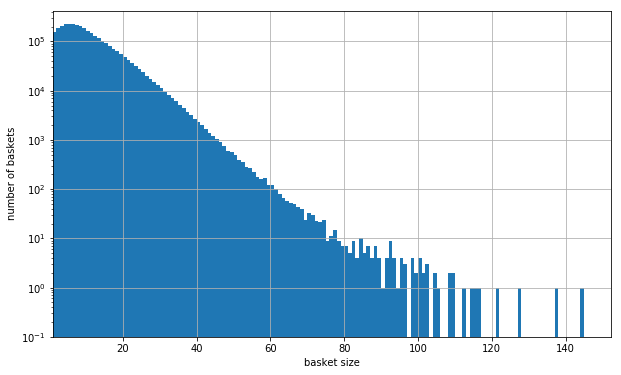

In [6]:
ax = pylab.gca()
n, bins, patches = pylab.hist(basket_sizes, bins = max_bs - min_bs, log = True)
pylab.xlabel('basket size')
pylab.ylabel('number of baskets')
pylab.xlim(xmin=1)
pylab.ylim(ymin=0.1)
pylab.grid()
pylab.show(ax)

In [7]:
#
# Now isn't that a comforting sight? The data contain a *lot* of structure!!
#
# At least for x > ~20, we see that the basket size in linear on a semilog-y
# scale; we are likely dealing with a geometric distrubition here. This
# distribution could arise very naturally in the following model. Given a
# shopping cart of size k, there is a constant probability p, independent of k,
# that at least one more item will be added to the cart, and a constant
# probability 1 - p that the customer will instead end the shopping trip. Under
# this assumption, we find:
#
#   P(basket size = N) = p**(N-1) * (1-p)
#
# where we use N-1 because the basket is guaranteed to be non-empty.
#
# Due to the initial rise of the distribution from 1 --> 6, this model clearly
# cannot be valid everywhere. We will consider other models below.
#

In [8]:
# Let's try a "fit" to an exponential distribution for "large" basket sizes. A
# simple, albeit crude way to estimate p is to take
#
#   p \approx (# baskets of size 26) / (# baskets of size 25)
#
# I chose sizes 26/25 to be safely away from the regime where the distribution
# is clearly not an exponential distribution but small enough to still have a
# large number of statistics (at 25, we still have ~20,000 representative
# baskets).  We could maybe do better by using the information from all baskets
# above some given basket size, but this is more exact than necessary for our 
# purposes here.
#

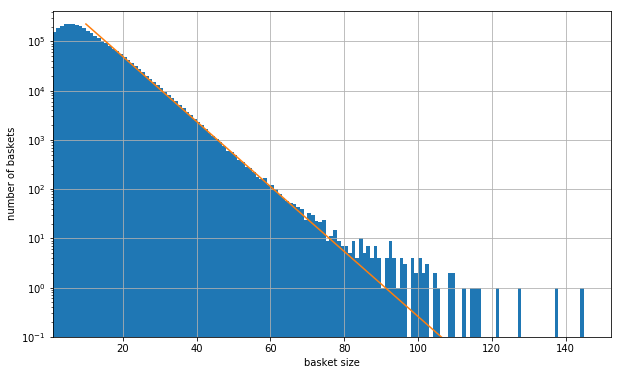

In [9]:
# FIXME: why do I have to do this again? If I don't do this, the figure only 
# shows the exponential fit. This must be some nonsense with the backend behavior ...
pylab.hist(basket_sizes, bins = max_bs - min_bs, log = True)
pylab.xlabel('basket size')
pylab.ylabel('number of baskets')
pylab.xlim(xmin=1)
pylab.ylim(ymin=0.1)
pylab.grid()


rbin = 25 # the basket size we use to calculate the "shopping termination probability"
p = float( len(basket_sizes[basket_sizes == rbin+1]) ) / float( len(basket_sizes[basket_sizes == rbin]) )
assert p < 1

# Generate a geometric distribution with this value of p
sbin = 10 # basket size down to which we will use the model
bins = np.linspace(sbin, max_bs, max_bs - sbin + 1) # ensure integer bins
expdist = p**(bins - sbin - 1) * (1 - p)

# Normalize only wrt to those points that we think are valid for this model
expdist *= len(basket_sizes[basket_sizes > sbin - 1])
pylab.plot(bins, expdist)
pylab.show(ax)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


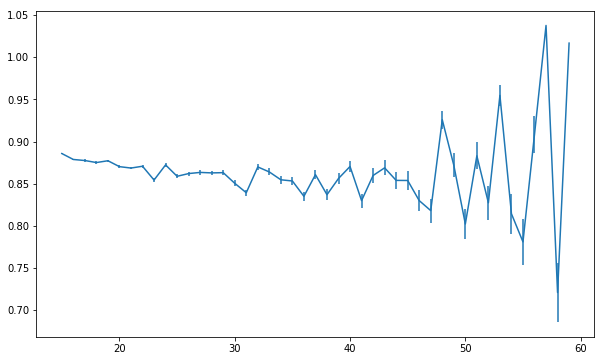

In [14]:
#
# This is not the least impressive agreement I've ever seen, suggesting the
# model is a good start to understanding to data. However, I note (not shown)
# that the quality of this fit greatly depends on which bin one uses for
# computing p. Perhaps, this is not surprising. Customers are not memory-less
# physical processes. A customer who has spent 10 hours online shopping is more
# likely to end his shopping experience in the next time unit than one who has
# spent only 10 minutes shopping.
#

### The "shopping termination probability" decreases with shopping duration
ps = []
perr = [] # frequentist estimation error
rbins = range(15, 60)
for rbin in rbins:
    # the basket size we use to calculate the "shopping termination probability"
    ps.append( float( len(basket_sizes[basket_sizes == rbin+1]) ) / float( len(basket_sizes[basket_sizes == rbin]) ))
    perr.append( np.sqrt(ps[-1] * (1 - ps[-1]) / len(basket_sizes[basket_sizes == rbin])) )

pylab.errorbar(rbins, ps, perr)
pylab.show()

In [56]:
#
# Another model that I initially considered was that of a Poisson process. Let's
# suppose the customer is mindlessly shopping at 3am because he or she can't
# sleep. Then there is a small but non-zero probability p that he orders any
# given item he is presented with on the shopping interface. After seeing N
# items, the total number of purchased items looks like a Poisson distribution
# with parameter lambda = N * p. Perhaps this model is appropriate for "small"
# basket sizes?? (For large basket sizes, the Poisson distribution falls off too
# fast to be appropriate here.)
#

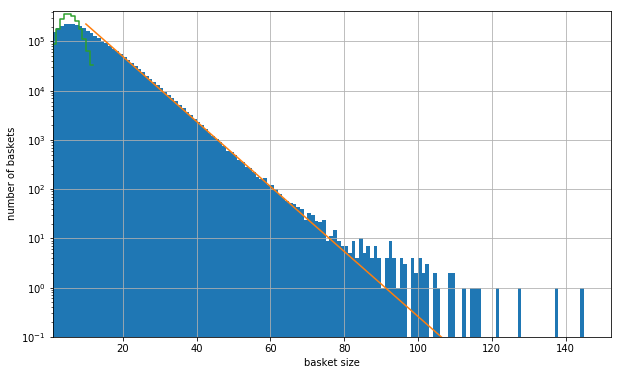

In [68]:
# FIXME: why do I have to do this again? If I don't do this, the figure only 
# shows the exponential fit. This must be some nonsense with the backend behavior ...
pylab.hist(basket_sizes, bins = max_bs - min_bs, log = True)
pylab.xlabel('basket size')
pylab.ylabel('number of baskets')
pylab.xlim(xmin=1)
pylab.ylim(ymin=0.1)
pylab.grid()

bins = np.linspace(sbin, max_bs, max_bs - sbin + 1) # ensure integer bins
pylab.plot(bins, expdist)

pbin = 12 # bin after which we assume Poisson is no good
mu = basket_sizes[basket_sizes <= pbin].mean()
bins = np.linspace(1, pbin, pbin)
poisson = np.array([np.exp(-mu) * mu**k / factorial(k) for k in bins])

# Since 0 is not a valid basket size, we need to renormalize the distribution
# (so it adds to 1). We then rescale the distribution by the given sample size
# to interpret it as the expectation value for a sample of this size
#  i.e., < # baskets of size k > = # baskets * P(k)
poisson = len(basket_sizes[basket_sizes <= pbin]) * poisson / sum(poisson)
pylab.step(bins, poisson)



In [69]:
# I haven't gained much confidence that there's anything Poissonian going
# on here ... so it remains to be seen how we should understand the small
# basket size limit ...